<a href="https://colab.research.google.com/github/akash-joshi/adversarial-examples/blob/master/fashion_mnist_keras_adversary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Overview

<br> **Notebook this is based on**: https://github.com/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb

This is a tutorial of how to classify **fashion_mnist** data with a  **VGG-like Convolutional Neural Network** in Keras and apply **foolbox** adversarial models to it.

The [fashion_mnist](https://github.com/zalandoresearch/fashion-mnist) data: 
60,000 train and 10,000 test data with 10 categories. Each gray-scale image is 28x28.

<br> **Label**	**Description**
<br> 0 T-shirt/top
<br> 1 Trouser
<br> 2 Pullover
<br> 3 Dress
<br> 4 Coat
<br> 5 Sandal
<br> 6 Shirt
<br> 7 Sneaker
<br> 8 Bag
<br> 9 Ankle boot

Each gray-scale image is 28x28

>>[Notebook Overview](#scrollTo=Ixyte299ZZgk)

>>[Download the fashion_mnist data](#scrollTo=LbCigZtNZZgl)

>>[Visualize the data](#scrollTo=tWORMSC8FDR4)

>>[Data normalization](#scrollTo=Zx-Ee6LHZZgt)

>>[Split the data into train/validation/test data sets](#scrollTo=CFlNHktHBtru)

>>[Create the model architecture](#scrollTo=HhalcO03ZZg3)

>>[Compile the model](#scrollTo=FhxJ5dinZZg8)

>>[Train the model](#scrollTo=DtOvh3YVZZg_)

>>[Load Model with the best validation accuracy](#scrollTo=e-MGLwZQy05d)

>>[Test Accuracy](#scrollTo=9RTRkan4yq5H)



## Download the fashion_mnist data
First let's install TensorFlow version 1.8.0 and import Tensorflow. Then we download fashion-mnist which is one of the Keras datasets. 

In [0]:
import cv2

In [0]:
!pip install -q -U tensorflow>=1.8.0
!pip install foolbox
!pip install tqdm

import tensorflow as tf
import foolbox

import numpy as np
import matplotlib.pyplot as plt



    100% |████████████████████████████████| 245kB 5.6MB/s 
  Running setup.py bdist_wheel for foolbox ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ef/09/46/9ae4db469491bd989b659a9dcb6cad8cc511751e6b6b335d96
Successfully built foolbox


In [0]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


## Visualize the data

x_train shape: (60000, 28, 28) y_train shape: (60000,)
60000 train set
10000 test set
y = 2 Pullover


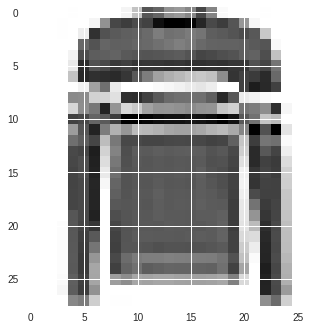

In [0]:
# Print training set shape - note there are 60,000 training data of image size of 28x28, 60,000 train labels)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training and test datasets
print(x_train.shape[0], 'train set')
print(x_test.shape[0], 'test set')

# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

# Image index, you can pick any number between 0 and 59,999
img_index = 5
# y_train contains the lables, ranging from 0 to 9
label_index = y_train[img_index]
# Print the label, for example 2 Pullover
print ("y = " + str(y_train[5]) + " " +(fashion_mnist_labels[label_index]))
# # Show one of the images from the training dataset
plt.imshow(x_train[img_index])

## Data normalization
Normalize the data dimensions so that they are of approximately the same scale.

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
print("Number of train data - " + str(len(x_train)))
print("Number of test data - " + str(len(x_test)))

Number of train data - 60000
Number of test data - 10000


## Split the data into train/validation/test data sets


*   Training data - used for training the model
*   Validation data - used for tuning the hyperparameters and evaluate the models
*   Test data - used to test the model after the model has gone through initial vetting by the validation set.



In [0]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

'''for i in y_train
  i = str(i)
for i in y_valid
  i = str(i)  
for i in y_test
  i = str(i)    '''

y_classes = y_test
# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


## Create the model architecture

There are two APIs for defining a model in Keras:
1. [Sequential model API](https://keras.io/models/sequential/)
2. [Functional API](https://keras.io/models/model/)

In this notebook we are using the Sequential model API. 
If you are interested in a tutorial using the Functional API, checkout Sara Robinson's blog [Predicting the price of wine with the Keras Functional API and TensorFlow](https://medium.com/tensorflow/predicting-the-price-of-wine-with-the-keras-functional-api-and-tensorflow-a95d1c2c1b03).

In defining the model we will be using some of these Keras APIs:
*   Conv2D() [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D/) - create a convolutional layer 
*   Pooling() [link text](https://keras.io/layers/pooling/) - create a pooling layer 
*   Dropout() [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - apply drop out 

In [0]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", 
          input_shape=x_train.shape[1:], activation='relu'))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 256)         0         
__________

## Compile the model
Configure the learning process with compile() API before training the model. It receives three arguments:

*   An optimizer 
*   A loss function 
*   A list of metrics 


In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## Train the model

Now let's train the model with fit() API.

We use  the [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint) API to save the model after every epoch. Set "save_best_only = True" to save only when the validation accuracy improves.


In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])
#Model made at this point

Using TensorFlow backend.


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
54976/55000 [============================>.] - ETA: 0s - loss: 0.5489 - acc: 0.7971
Epoch 00001: val_loss improved from inf to 0.31244, saving model to model.weights.best.hdf5
55000/55000 [==============================] - 30s 540us/step - loss: 0.5488 - acc: 0.7971 - val_loss: 0.3124 - val_acc: 0.8854
Epoch 2/10
54976/55000 [============================>.] - ETA: 0s - loss: 0.3460 - acc: 0.8729
Epoch 00002: val_loss improved from 0.31244 to 0.26407, saving model to model.weights.best.hdf5
55000/55000 [==============================] - 25s 450us/step - loss: 0.3461 - acc: 0.8730 - val_loss: 0.2641 - val_acc: 0.8980
Epoch 3/10
54976/55000 [============================>.] - ETA: 0s - loss: 0.3014 - acc: 0.8896
Epoch 00003: val_loss improved from 0.26407 to 0.22037, saving model to model.weights.best.hdf5
55000/55000 [==============================] - 25s 448us/step - loss: 0.3016 - acc: 0.8896 - val_loss: 0.2204 - val_acc: 0.916

## Load Model and Generate Adversary


In [0]:
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')
network = tf.keras.models.load_model('model.weights.best.hdf5')
foolbox_model = foolbox.models.TensorFlowModel.from_keras(model = network,bounds = (0.0, 1.0))




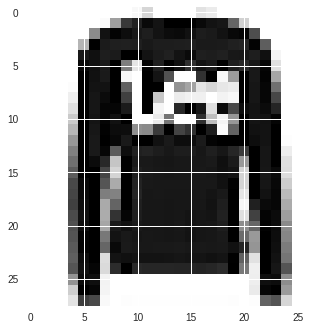

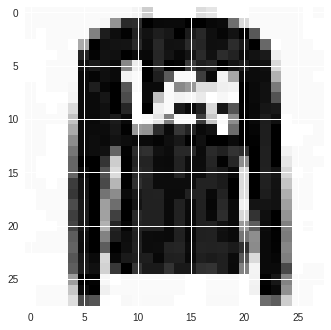

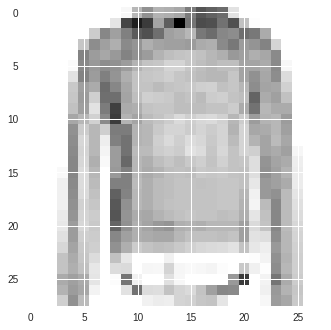

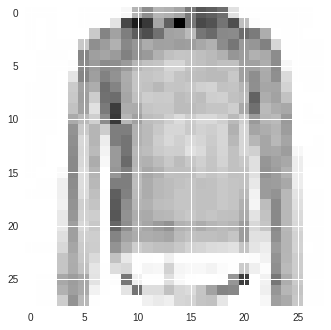

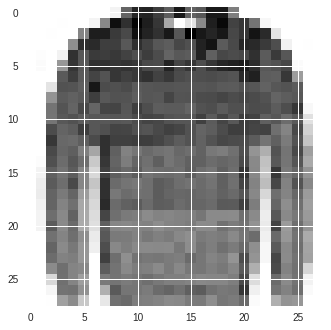

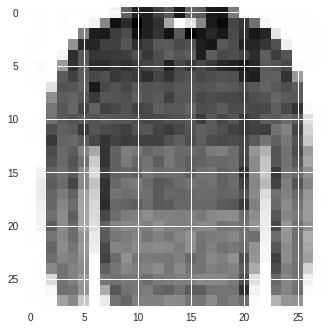

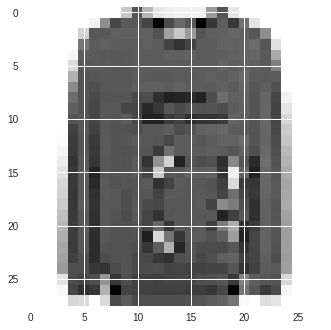

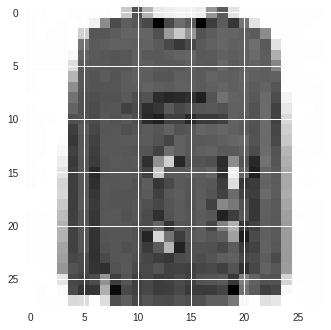

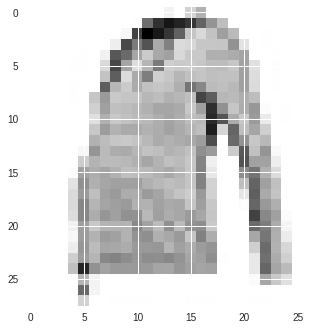

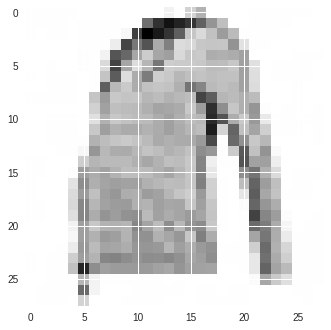

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


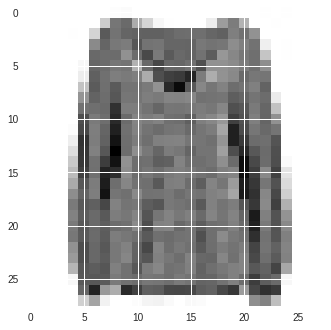

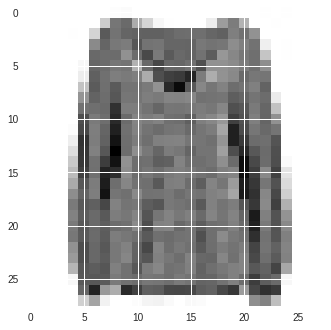

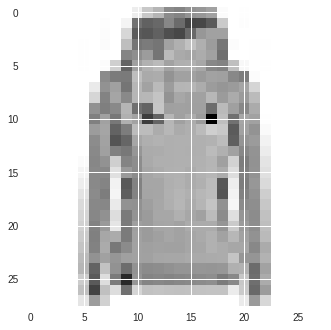

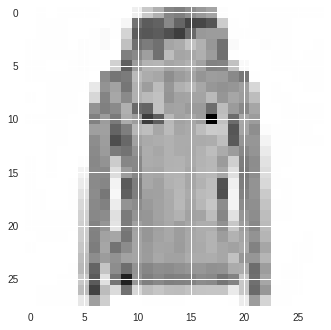

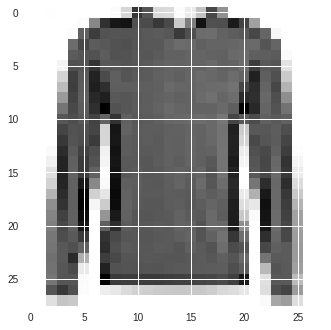

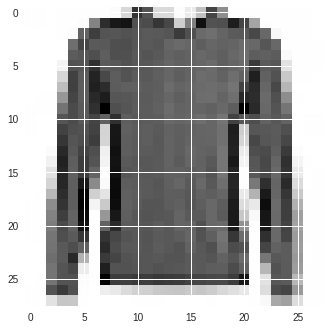

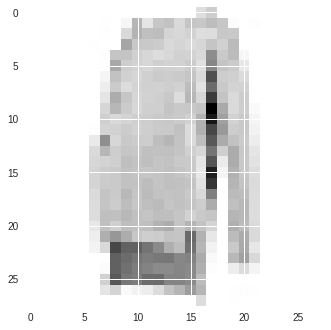

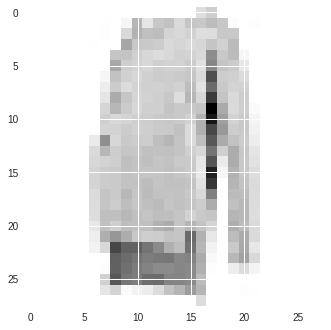

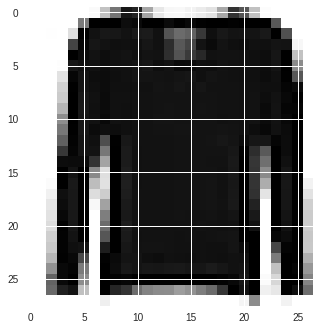

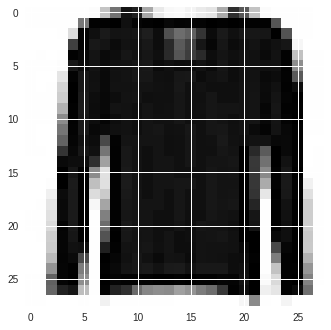

Average noise is  0.3796639174222946


In [0]:
attack_fgsm = foolbox.attacks.FGSM(foolbox_model)
count = 0
sum = 0
for i in range(1,200):
  if(y_classes[i]==2):
    image = x_test[i]
    adversarial = attack_fgsm(image,label = y_classes[i])
    plt.imshow(np.squeeze(x_test[i]))
    plt.show()
    plt.imshow(np.squeeze(adversarial))
    plt.show()
    pred = network.predict(image.reshape(1,w,h,1))
    adver_pred = network.predict(adversarial.reshape(1,w,h,1))
    #print(pred[0][y_classes[i]] - adver_pred[0][y_classes[i]],"decrease in accuracy")
    count+=1
    sum+=(pred[0][y_classes[i]] - adver_pred[0][y_classes[i]])
  if(count==10):
    break
    
sum/=10
print("Average noise is ",sum)

In [0]:
attack_pixel = foolbox.attacks.LocalSearchAttack(foolbox_model)
count = 0
sum = 0
for i in range(1,200):
  if(y_classes[i]==2):
    image = x_test[i]
    adversarial = attack_pixel(image,label = y_classes[i])
    
    if adversarial is None:
      continue
      
    pred = network.predict(image.reshape(1,w,h,1))
    adver_pred = network.predict(adversarial.reshape(1,w,h,1))
    #print(pred[0][y_classes[i]] - adver_pred[0][y_classes[i]],"decrease in accuracy")
    count+=1
    sum+=(pred[0][y_classes[i]] - adver_pred[0][y_classes[i]])
  if(count==10):
    break
    
sum/=10
print("Average noise is ",sum)

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


Average noise is  0.43061414510011675


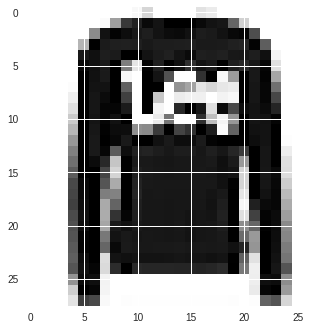

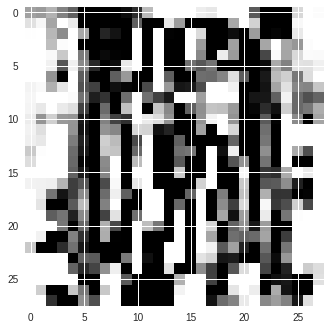

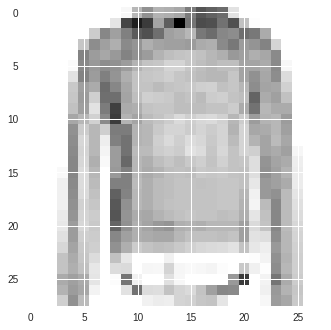

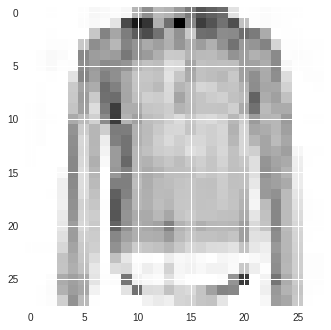

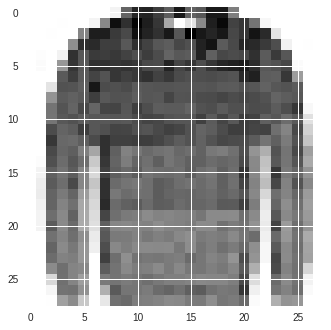

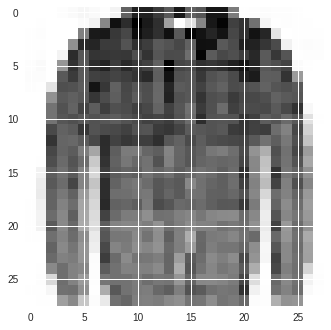

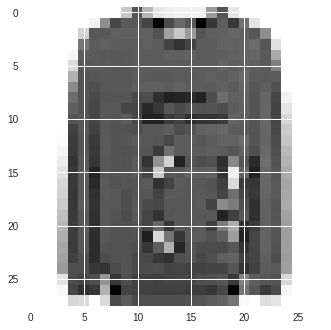

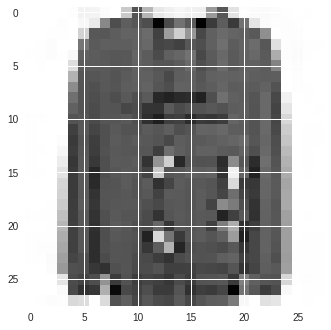

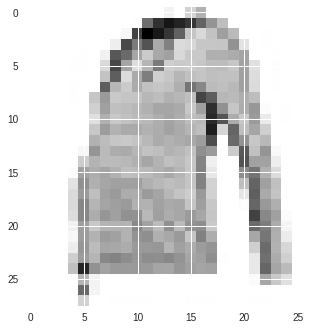

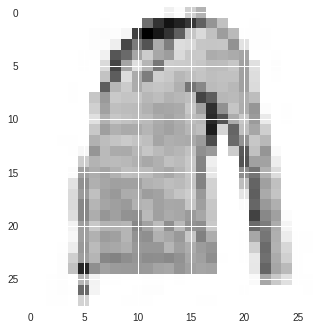

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


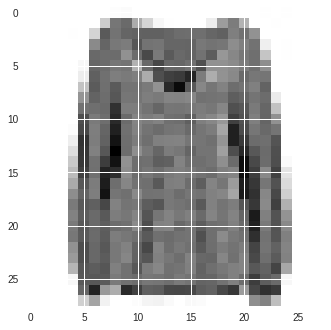

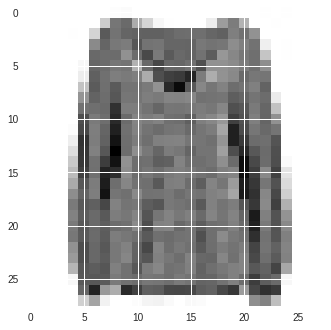

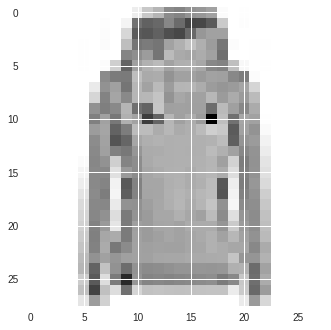

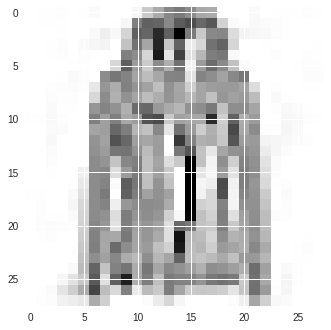

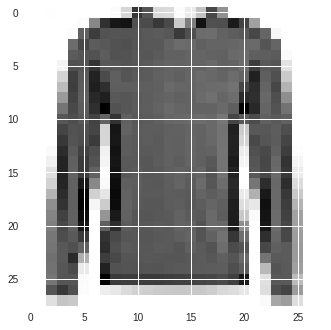

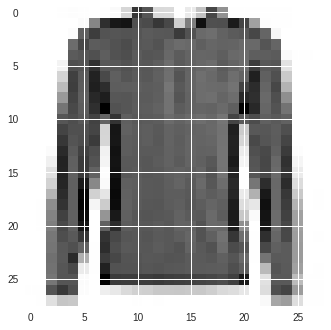

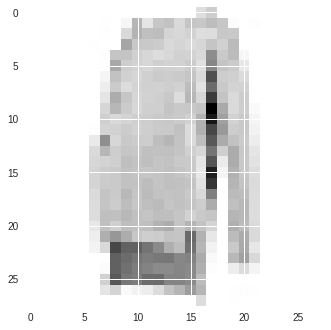

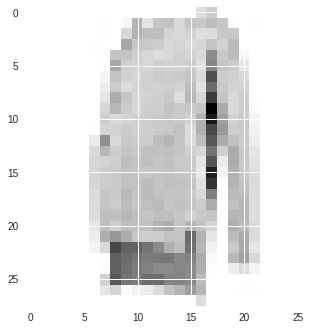

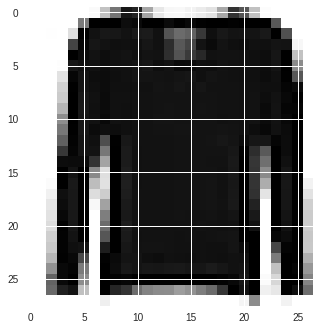

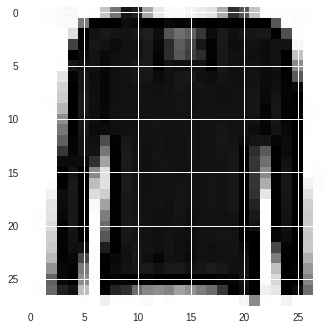

Average noise is  0.5916935473680496


In [0]:
attack_df = foolbox.attacks.DeepFoolAttack(foolbox_model)
count = 0
sum = 0
for i in range(1,200):
  if(y_classes[i]==2):
    image = x_test[i]
    adversarial = attack_df(image,label = y_classes[i])
    if adversarial is None:
      continue
    plt.imshow(np.squeeze(x_test[i]))
    plt.show()
    plt.imshow(np.squeeze(adversarial))
    plt.show()  
    pred = network.predict(image.reshape(1,w,h,1))
    adver_pred = network.predict(adversarial.reshape(1,w,h,1))
    #print(pred[0][y_classes[i]] - adver_pred[0][y_classes[i]],"decrease in accuracy")
    count+=1
    sum+=(pred[0][y_classes[i]] - adver_pred[0][y_classes[i]])
  if(count==10):
    break
    
sum/=10
print("Average noise is ",sum)
  
    

## Test Accuracy

In [0]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)
#adver_s = network.evaluate(adversarial,y_test,verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
#print('\n','Advers: ',adver_s[1])


 Test accuracy: 0.9185
